## MSBX 5420 Assignment 4
This assignment includes two parts: (1) Graph analysis with Spark GraphFrames (Task 1 and 2); (2) Load data from MySQL database and do a simple analysis (Task 3). Two datasets are used in the assignment - facebook social networks (Task 1) and reddit community links (Task 2). For task 3, we will continue our class exercise with `employees` database.

### Task 1 - Graph Analysis on Facebook Networks

The data is from Facebook circles. For social networks, the data sometimes looks simple but boring - to protect privacy, only (recoded) user id is available and each row in the data is the connection or friendship from one user to another. 

Let's first load graphframes package and build the graph.

In [ ]:
#in case you need to download the graphframes package
#!wget http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
#if you encounter issues on MyBinder, you may reinstall pyspark package
#!pip install pyspark

In [1]:
#for cluster, switch kernel to PySpark, and use yarn or spark://spark-master:7077 in master()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[4]') \
                    .config("spark.executor.memory", "1g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.jars", "mysql-connector-java-8.0.23.jar, graphframes-0.8.1-spark3.0-s_2.12.jar") \
                    .config("spark.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12") \
                    .appName('spark_graph').getOrCreate()

In [2]:
#make sure graphframes-0.8.1-spark3.0-s_2.12.jar is under same directory
sc = spark.sparkContext
sc.addPyFile('graphframes-0.8.1-spark3.0-s_2.12.jar')
#if on the cluster
#sc = spark.sparkContext
#sc.addPyFile('s3://msbx5420-spr21/zhiyiwang/graphframes-0.8.1-spark3.0-s_2.12.jar')

In [3]:
#first read the dataset
import pyspark.sql.functions as fn

#this is a txt file without header so after reading data we use .toDF() to add column names
#for cluster, read files under s3://msbx5420-spr21/zhiyiwang/
fb_connection = spark.read.csv('./facebook_combined.txt.gz', sep=' ').toDF('from', 'to')
fb_connection.show()

+----+---+
|from| to|
+----+---+
|   0|  1|
|   0|  2|
|   0|  3|
|   0|  4|
|   0|  5|
|   0|  6|
|   0|  7|
|   0|  8|
|   0|  9|
|   0| 10|
|   0| 11|
|   0| 12|
|   0| 13|
|   0| 14|
|   0| 15|
|   0| 16|
|   0| 17|
|   0| 18|
|   0| 19|
|   0| 20|
+----+---+
only showing top 20 rows



Create vertices and edges dataframes, with `id` for vertices, and `src` / `dst` for edges.

In [4]:
#create vertices dataframe
fb_vertices = fb_connection.select(fn.col('from').alias('id')).union(fb_connection.select(fn.col('to').alias('id'))).distinct()
fb_vertices.count()

4039

Because Graphframes by default uses multi-directed graph and there is no "undirected" definition, we need to "duplicate" the edges to have two edges between two nodes to capture their friend relationship on Facebook.

In [5]:
#create edges dataframe
fb_edges = fb_connection.union(fb_connection.select(fn.col('to').alias('from'),fn.col('from').alias('to'))) \
                        .withColumnRenamed('from', 'src').withColumnRenamed('to', 'dst').distinct()
fb_edges.show()
fb_edges.count()

+---+----+
|src| dst|
+---+----+
|  0| 258|
|  0| 294|
|  9| 134|
| 13| 332|
| 40| 200|
| 64| 150|
| 81| 286|
| 87| 291|
|107|1161|
|107|1452|
|107|1522|
|107|1541|
|107|1640|
|107|1829|
|141| 258|
|180| 302|
|186| 325|
|198| 351|
|251| 281|
|257| 344|
+---+----+
only showing top 20 rows



176468

In total the data contains 4,039 users and 176,468 edges (bi-directional friendship), consistent with the data description. Then we can build the graph with the two dataframes.

In [6]:
from graphframes import *
#build graph
fb_graph = GraphFrame(fb_vertices, fb_edges)
print(fb_graph)

GraphFrame(v:[id: string], e:[src: string, dst: string])


Let's first get degree centrality. Because friendship tie in Facebook is essentially undirected (bi-directional in our data setup), inDegree and outDegree are actually same here.

In [7]:
#because this is an undirected graph (Facebook only has friendship, not following / followed), inDegree and outDegree are same here
fb_graph.inDegrees.sort(fn.desc("inDegree")).show()
fb_graph.outDegrees.sort(fn.desc("outDegree")).show()

+----+--------+
|  id|inDegree|
+----+--------+
| 107|    1045|
|1684|     792|
|1912|     755|
|3437|     547|
|   0|     347|
|2543|     294|
|2347|     291|
|1888|     254|
|1800|     245|
|1663|     235|
|1352|     234|
|2266|     234|
| 483|     231|
| 348|     229|
|1730|     226|
|1985|     224|
|1941|     223|
|2233|     222|
|2142|     221|
|1431|     220|
+----+--------+
only showing top 20 rows

+----+---------+
|  id|outDegree|
+----+---------+
| 107|     1045|
|1684|      792|
|1912|      755|
|3437|      547|
|   0|      347|
|2543|      294|
|2347|      291|
|1888|      254|
|1800|      245|
|1663|      235|
|1352|      234|
|2266|      234|
| 483|      231|
| 348|      229|
|1730|      226|
|1985|      224|
|1941|      223|
|2233|      222|
|2142|      221|
|1431|      220|
+----+---------+
only showing top 20 rows



Now let's calculate pagerank to see who are the important ones in the network.

In [8]:
#[Your Code] to calculate pagerank on the graph and display nodes with top pageranks
pageranks = fb_graph.pageRank(resetProbability=0.15, maxIter=10)
pageranks.vertices.orderBy('pagerank', ascending=False).show()

+----+------------------+
|  id|          pagerank|
+----+------------------+
|3437| 30.71262334133324|
| 107| 27.95293152166756|
|1684|25.650035103130204|
|   0|25.334393451228593|
|1912|15.596358338708859|
| 348| 9.452794613785988|
| 686| 8.958867225621194|
|3980| 8.744318131873408|
| 414| 7.257851462730177|
| 698| 5.294338484405194|
| 483| 5.241191020097799|
|3830| 4.785554248921855|
| 376|3.6397567473065116|
|2047|3.3886844614736233|
|  56|3.2551355363248122|
|  25|3.2376027513436347|
| 828| 3.191946206586023|
| 322| 3.183769275471551|
| 475| 3.170878373788124|
| 428| 3.148450434395013|
+----+------------------+
only showing top 20 rows



Shortest path is useful in many cases. Note that the `shortestPaths()` function in Grapgframes will actually calculate shortest distances (number of edges) from each node in the graph to all the nodes specified in `landmarks`. Here we want to calculate all the shortest paths from all users to two sample users with `id` of `0` and `25`, and then see the distribution of shortest distances from all users to them. So we first need to calculate shortest paths on the graph and extract the distance information.

In [9]:
#[Your Code] to calculate shortest paths from all nodes to node id 0 and 25
shortest_path = fb_graph.shortestPaths(landmarks=['0', '25'])

Then we check the distribution of distances from all nodes to node 0 and 25.

In [10]:
#check the distribution of distances to node 0 and 25
shortest_path.select(fn.map_values('distances')[1].alias('distance')).groupBy('distance').count().orderBy('distance').show()
shortest_path.select(fn.map_values('distances')[0].alias('distance')).groupBy('distance').count().orderBy('distance').show()

+--------+-----+
|distance|count|
+--------+-----+
|       0|    1|
|       1|   69|
|       2|  278|
|       3| 1171|
|       4| 1742|
|       5|  519|
|       6|  117|
|       7|  142|
+--------+-----+

+--------+-----+
|distance|count|
+--------+-----+
|       0|    1|
|       1|  347|
|       2| 1171|
|       3| 1742|
|       4|  519|
|       5|  117|
|       6|  142|
+--------+-----+



Next we want to know the structure of this network, so we can get the clusters. We use label propagation to identify clusters, and show the number of clusters as well as size of clusters in the end.

In [11]:
#[Your Code] to use label propagation to identify clusters in the network; then show the total number of clusters you get and the size of each cluster.
clusters = fb_graph.labelPropagation(maxIter=10)
clusters.orderBy(fn.asc('label')).show()
clusters.select('label').groupBy('label').count().show()
clusters.select('label').distinct().count()

+----+------------+
|  id|       label|
+----+------------+
| 858| 17179869203|
| 866| 17179869203|
| 871| 17179869203|
| 879| 17179869203|
| 870| 17179869203|
| 894| 17179869203|
| 881| 17179869203|
| 895| 17179869203|
|3489| 25769803789|
|3676| 25769803789|
|3141|283467841553|
|3354|283467841553|
|2857|283467841553|
|2861|283467841553|
|3200|283467841553|
|3216|283467841553|
|2799|283467841553|
|3105|283467841553|
|2776|283467841553|
|3122|283467841553|
+----+------------+
only showing top 20 rows

+-------------+-----+
|        label|count|
+-------------+-----+
| 721554505733|   21|
|  25769803789|    2|
| 987842478090|   19|
| 360777252880|    6|
|1382979469321|    4|
| 618475290626|  461|
| 360777252871|   43|
| 841813590037|   15|
|1082331758594|    8|
| 386547056646|   73|
| 575525617679|   16|
| 910533066766|   30|
| 867583393808|   96|
| 377957122059|  140|
| 386547056649|   13|
| 446676598802|   19|
| 893353197578|  237|
| 747324309521|   42|
|1013612281871|  226|
| 30923764

67

We will do a visualization here. You may try the code below, but it is not required.

In [12]:
#visualize the network
import networkx as nx
import pandas as pd

#turn the large network into a smaller one and create network from pandas
vertice = fb_graph.vertices.toPandas()
edges = fb_graph.edges.toPandas()
ranks = pageranks.vertices.toPandas()
labels = clusters.toPandas()

vertice.index = vertice['id']
ranks.index = ranks['id']
labels.index = labels['id']

ranks['pagerank'] = ranks['pagerank'] * 20

graph = nx.from_pandas_edgelist(edges, 'src',  'dst')
nx.set_node_attributes(graph, pd.Series(vertice.id, index=vertice.id).to_dict(), 'label')
nx.set_node_attributes(graph, pd.Series(ranks.pagerank, index=ranks.id).to_dict(), 'size')
nx.set_node_attributes(graph, pd.Series(labels.label, index=labels.id).to_dict(), 'group')

In [13]:
#here networkx will recognize the graph as simple graph
print(len(graph.nodes()))
print(len(graph.edges()))

4039
88234


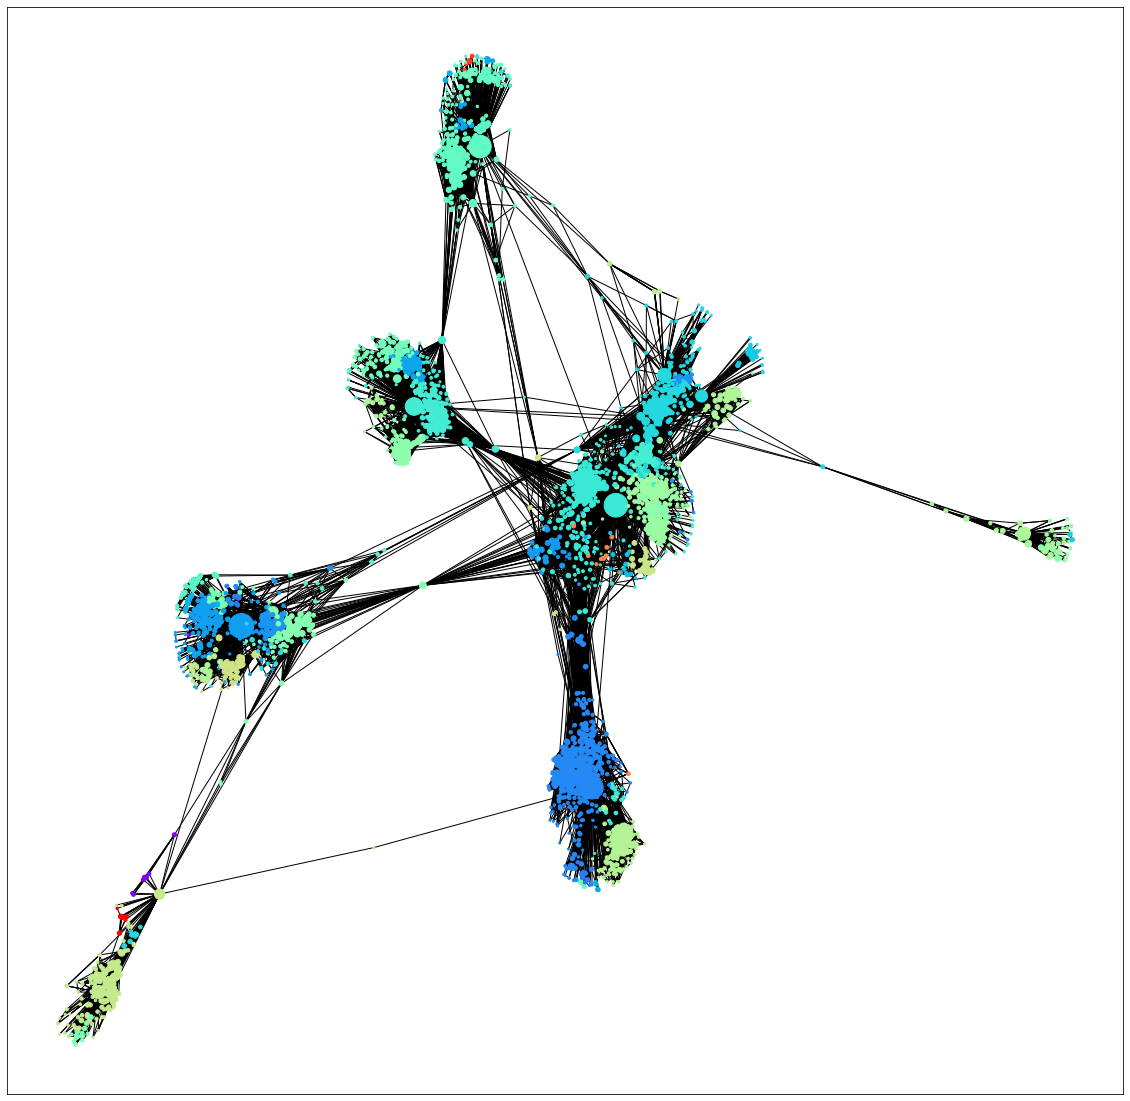

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 20]

pos = nx.spring_layout(graph, iterations=100)
nx.draw_networkx_nodes(graph, pos = pos, node_size = list(nx.get_node_attributes(graph, 'size').values()), node_color = list(nx.get_node_attributes(graph, 'group').values()), cmap = plt.cm.get_cmap('rainbow'))
nx.draw_networkx_edges(graph, pos = pos)
plt.show()

### Task 2 - Graph Analysis on Reddit Communities
We will work on a different graph dataset from Reddit in Task 2. Reddit is a large community for discussing different topics. In reddit, there are subreddits for specific topics. In particular, one community (subreddit) links to another community (subreddit) when a post refers to another post in another community. Therefore, the data here contains the posts from 2014 to 2017 that contain hyperlinks of another different subreddit. The data contains two parts, one is the hyperlinks in the body of reddit posts, the other is the hyperlinks in the title of reddit posts.

In [15]:
import pyspark.sql.functions as fn

#read data, two data files in total; for cluster read files under s3://msbx5420-spr21/zhiyiwang/
reddit_link = spark.read.csv('./reddit_hyperlinks.csv.gz', header=True, inferSchema=True, sep=',')
reddit_link.show()
reddit_link_title = spark.read.csv('./reddit_hyperlinks_title.csv.gz', header=True, inferSchema=True, sep=',')
reddit_link_title.show()

+----------------+----------------+-------+----------------+--------------+
|SOURCE_SUBREDDIT|TARGET_SUBREDDIT|POST_ID|       TIMESTAMP|LINK_SENTIMENT|
+----------------+----------------+-------+----------------+--------------+
| leagueoflegends| teamredditteams|1u4nrps|12/31/2013 16:39|             1|
|      theredlion|          soccer| 1u4qkd|12/31/2013 18:18|            -1|
|    inlandempire|          bikela|1u4qlzs|  1/1/2014 14:54|             1|
|             nfl|             cfb|1u4sjvs|12/31/2013 17:37|             1|
|      playmygame|         gamedev|1u4w5ss|   1/1/2014 2:51|             1|
|      dogemarket|        dogecoin|1u4w7bs|12/31/2013 18:35|             1|
|     locationbot|     legaladvice|1u4wfes|  1/7/2014 20:17|             1|
|       indiefied|             aww|1u50pos|  3/3/2014 17:00|             1|
|    posthardcore|      bestof2013|1u5ccus|12/31/2013 23:16|             1|
|    posthardcore|        corejerk|1u5ccus|12/31/2013 23:16|             1|
|          g

Here we union the two dataframes first and then create the vertices/edges dataframes.

In [16]:
reddit_link_all = reddit_link.union(reddit_link_title)

In [17]:
#create vertices dataframe
reddit_vertices = reddit_link_all.select(fn.col('SOURCE_SUBREDDIT').alias('id')) \
                                 .union(reddit_link_all.select(fn.col('TARGET_SUBREDDIT').alias('id'))).distinct()
reddit_vertices.count()

67180

In [18]:
#create edges dataframe
reddit_edges = reddit_link_all.withColumnRenamed('SOURCE_SUBREDDIT', 'src').withColumnRenamed('TARGET_SUBREDDIT', 'dst')
reddit_edges.show()
reddit_edges.count()

+---------------+---------------+-------+----------------+--------------+
|            src|            dst|POST_ID|       TIMESTAMP|LINK_SENTIMENT|
+---------------+---------------+-------+----------------+--------------+
|leagueoflegends|teamredditteams|1u4nrps|12/31/2013 16:39|             1|
|     theredlion|         soccer| 1u4qkd|12/31/2013 18:18|            -1|
|   inlandempire|         bikela|1u4qlzs|  1/1/2014 14:54|             1|
|            nfl|            cfb|1u4sjvs|12/31/2013 17:37|             1|
|     playmygame|        gamedev|1u4w5ss|   1/1/2014 2:51|             1|
|     dogemarket|       dogecoin|1u4w7bs|12/31/2013 18:35|             1|
|    locationbot|    legaladvice|1u4wfes|  1/7/2014 20:17|             1|
|      indiefied|            aww|1u50pos|  3/3/2014 17:00|             1|
|   posthardcore|     bestof2013|1u5ccus|12/31/2013 23:16|             1|
|   posthardcore|       corejerk|1u5ccus|12/31/2013 23:16|             1|
|         gfycat|          india|1u5df

858488

Now build the graph with the two dataframes.

In [19]:
from graphframes import *
#build graph
reddit_graph = GraphFrame(reddit_vertices, reddit_edges)
print(reddit_graph)

GraphFrame(v:[id: string], e:[src: string, dst: string ... 3 more fields])


Let's start with degree centrality again. Here the importance of a community is better approximated by the links *to* the community (the posts in the community were referred in other communities), so we use inDegree centrality.

In [20]:
reddit_graph.inDegrees.sort(fn.desc("inDegree")).show()

+---------------+--------+
|             id|inDegree|
+---------------+--------+
|      askreddit|   26622|
|           iama|   13446|
|           pics|   12578|
|  todayilearned|   11124|
|          funny|   10777|
|         videos|   10013|
|      worldnews|    9944|
|           news|    7692|
|       politics|    6114|
|         gaming|    6097|
|  adviceanimals|    5503|
|            wtf|    5320|
|           gifs|    5214|
| writingprompts|    5056|
|leagueoflegends|    4856|
|        science|    4557|
|     the_donald|    4487|
| showerthoughts|    4202|
|        bitcoin|    4028|
|            nfl|    4000|
+---------------+--------+
only showing top 20 rows



Now let's use pagerank to determine the importance of community and show the top ones.

In [21]:
#[Your Code] to use pagerank to identify the most important communities based on the hyperlinks and display the top ones
pageranks = reddit_graph.pageRank(resetProbability=0.15, maxIter=10)
pageranks.vertices.orderBy(pageranks.vertices.pagerank.desc()).show()

+---------------+------------------+
|             id|          pagerank|
+---------------+------------------+
|      askreddit|1476.6609739919988|
|           iama|  1214.21226182575|
|           pics| 760.4123156397624|
|          funny| 674.5452991662956|
|         videos| 630.9012109013033|
|  todayilearned|471.49349802712356|
|      worldnews| 426.3987174182764|
|         gaming| 397.1764869673869|
|           news|331.88172242160283|
|        science|  301.530229177491|
|           gifs|   285.28841147785|
|          books|280.54448906793704|
|leagueoflegends|278.34614119089315|
|            wtf|253.68655962231225|
|       politics| 245.0716135214568|
| showerthoughts| 237.0580361391196|
|  adviceanimals|233.57209007542892|
|         movies|228.74348589035688|
|        bitcoin|227.32469616242994|
|          music|221.76543286241272|
+---------------+------------------+
only showing top 20 rows



In the data, one column is the sentiment of the post with hyperlinks from one subreddit to another. So we can learn whether or not this is a positive post referring another subreddit. In other words, some posts might be negative when referring to the posts in other subreddits, implying that some communities may have conflicts. Can you identify which pairs of communities are more likely to have conflicts?

To do this, we can perform a query on the edges in the graph. Basically, we can obtain the average sentiment (`LINK_SENTIMENT` column) from one subreddit to another. To make sure this is not random, we should ONLY consider those pairs of communities with *at least 10 hyperlinks from one to another*.

In [22]:
#[Your Code] to identify the communities with significant conflicts
reddit_graph.edges.groupBy('src', 'dst').agg(fn.avg('LINK_SENTIMENT').alias('avg_sentiment'), fn.count('*').alias('count')).filter('count>=10').orderBy('avg_sentiment').show()

+------------------+--------------------+--------------------+-----+
|               src|                 dst|       avg_sentiment|count|
+------------------+--------------------+--------------------+-----+
|           sjwnews|              videos| -0.8181818181818182|   11|
|        botsrights|        wackytictacs|                -0.8|   10|
|     shitgnomesays|               gnome|                -0.8|   10|
| publichealthwatch|            abortion| -0.7647058823529411|   17|
| publichealthwatch|                news| -0.7142857142857143|   14|
|           sjwnews|       adviceanimals| -0.6666666666666666|   12|
|       hearthstone|hearthstonecircle...| -0.6410256410256411|   39|
|  angryblackladies|          gamerghazi| -0.6363636363636364|   11|
|      circlebroke2|                 mma| -0.6363636363636364|   11|
|  topcuntsofreddit|          conspiracy|                -0.6|   10|
| publichealthwatch|              progun|                -0.6|   10|
|            bestof|         nonon

Next let's perform some searches on the graph. Assume you are a random walker in reddit communities - you just randomly browse posts without targeting any particular communities. Now assume you start your browsing trip in the `leagueoflegends` commuity (League of Legends is a Multiplayer Online Battle Arena (MOBA) e-sports video game). Now we are wondering whether (and in what way) you have a chance to reach other communities through the hyperlinks between communities. To do this, we can use breath-first search or motif finding.

Note that this is not likely to be a real action in practice and it is also not the actual role of those hyperlinks. We just use it as a simulated case of graph search. Now let's first see if you can reach `politics` community from `leagueoflegends` community directly.

In [23]:
paths = reddit_graph.bfs(fromExpr = "id = 'leagueoflegends'", toExpr = "id = 'politics'", maxPathLength = 1)
paths.show(truncate=False)

+---+
|id |
+---+
+---+



It seems no direct hyperlinks from `leagueoflegends` subreddit to `politics` subreddit. Therefore, we should check if there are shortest paths with length of 2 so that we may still reach `politics` community through another community. Can you identify those paths through `both` breath-first search and motif finding?

In [24]:
#[Your Code] to use breath-first search to find possible shortest paths from leagueoflegends to politics
paths = reddit_graph.bfs(fromExpr = "id = 'leagueoflegends'", toExpr = "id = 'politics'", maxPathLength = 2)
paths.show(truncate=False)

+-----------------+------------------------------------------------------------+--------------+-----------------------------------------------------+----------+
|from             |e0                                                          |v1            |e1                                                   |to        |
+-----------------+------------------------------------------------------------+--------------+-----------------------------------------------------+----------+
|{leagueoflegends}|{leagueoflegends, greece, 47lojus, 2/25/2016 13:43, 1}      |{greece}      |{greece, politics, 56m7ofs, 10/9/2016 6:17, 1}       |{politics}|
|{leagueoflegends}|{leagueoflegends, videos, 2h3gais, 9/21/2014 21:45, 1}      |{videos}      |{videos, politics, 2ng23us, 11/25/2014 20:09, 1}     |{politics}|
|{leagueoflegends}|{leagueoflegends, videos, 2h3gais, 9/21/2014 21:45, 1}      |{videos}      |{videos, politics, 66z0ras, 4/22/2017 16:10, 1}      |{politics}|
|{leagueoflegends}|{leagueoflegend

In [25]:
#[Your Code] to use motif finding to find possible shortest paths from leagueoflegends to politics
motifs = reddit_graph.find("(a)-[ab]->(b); (b)-[bc]->(c)")\
                     .filter("(a.id = 'leagueoflegends') and (c.id = 'politics')")
motifs.show(truncate=False)

+-----------------+------------------------------------------------------------+--------------+-----------------------------------------------------+----------+
|a                |ab                                                          |b             |bc                                                   |c         |
+-----------------+------------------------------------------------------------+--------------+-----------------------------------------------------+----------+
|{leagueoflegends}|{leagueoflegends, greece, 47lojus, 2/25/2016 13:43, 1}      |{greece}      |{greece, politics, 56m7ofs, 10/9/2016 6:17, 1}       |{politics}|
|{leagueoflegends}|{leagueoflegends, videos, 2h3gais, 9/21/2014 21:45, 1}      |{videos}      |{videos, politics, 2ng23us, 11/25/2014 20:09, 1}     |{politics}|
|{leagueoflegends}|{leagueoflegends, videos, 2h3gais, 9/21/2014 21:45, 1}      |{videos}      |{videos, politics, 66z0ras, 4/22/2017 16:10, 1}      |{politics}|
|{leagueoflegends}|{leagueoflegend

### Task 3 - Read Data from MySQL
As the last task in all assignments, you will see no existing code and you will do a simple task on your own. 

The task is to read data from MySQL database. You need to follow the steps and commands in class exercise to have a MySQL database available in docker and import the `employees` datababase. Then read data from the `dept_emp` table (employee-department table).

After reading the data into a spark dataframe, we are wondering which employees have been at more than one department. As we mentioned in the class, those employees that connect multiple groups may be structural holes to have comparative advantages. Even though the social network is not available for employees in this database, we may approximate this concept by identifying those employees who have worked in more than one department. This is just a rough calculation.

In the table, there are columns `from_date` and `to_date`. Fot `to_date`, if it is `9999-01-01`, the employee is still at the company by the time of data collection (current employee). Therefore, we want to filter those employees with `to_date` as `9999-01-01` and with more than one records in the `dept_emp` table. That's what you will obtain eventually - you can use either dataframe operations or sql, and use `.show()` to display the results you obtain.

In [26]:
#[Your Code] to read data from dept_emp table and filter current employees who have worked at more than one department
#for cluster, MySQL is at ip-172-16-0-110:3306 rather than localhost:3306; the username and password are same with the class exercise
dept_employee_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/employees") \
                   .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "dept_emp") \
                   .option("user", "admin").option("password", "Admin_01").load()
dept_employee_df.show()

emm_num_dept = dept_employee_df.groupBy('emp_no').agg(fn.count('dept_no').alias('num_dept'))
emm_mul_dept = dept_employee_df.join(emm_num_dept, 'emp_no').where("to_date = '9999-01-01' and num_dept > 1")
emm_mul_dept.show()

+------+-------+----------+----------+
|emp_no|dept_no| from_date|   to_date|
+------+-------+----------+----------+
| 10001|   d005|1986-06-26|9999-01-01|
| 10002|   d007|1996-08-03|9999-01-01|
| 10003|   d004|1995-12-03|9999-01-01|
| 10004|   d004|1986-12-01|9999-01-01|
| 10005|   d003|1989-09-12|9999-01-01|
| 10006|   d005|1990-08-05|9999-01-01|
| 10007|   d008|1989-02-10|9999-01-01|
| 10008|   d005|1998-03-11|2000-07-31|
| 10009|   d006|1985-02-18|9999-01-01|
| 10010|   d004|1996-11-24|2000-06-26|
| 10010|   d006|2000-06-26|9999-01-01|
| 10011|   d009|1990-01-22|1996-11-09|
| 10012|   d005|1992-12-18|9999-01-01|
| 10013|   d003|1985-10-20|9999-01-01|
| 10014|   d005|1993-12-29|9999-01-01|
| 10015|   d008|1992-09-19|1993-08-22|
| 10016|   d007|1998-02-11|9999-01-01|
| 10017|   d001|1993-08-03|9999-01-01|
| 10018|   d004|1992-07-29|9999-01-01|
| 10018|   d005|1987-04-03|1992-07-29|
+------+-------+----------+----------+
only showing top 20 rows

+------+-------+----------+----------+